## Import Modules

In [0]:


import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as ml
import torch.nn.functional as F
import copy
import math
import nltk
torch.manual_seed(1)

## Input Parameters

Best Scenario Details:
*   Input - Word2Vec, Character Embedding (Bi-LSTM)
*   Attention [Layer, Type] - [Self Attention, LSTM Output, Scaled Dot Product], [Self Attention, Imput Embedding, Dot Product]
*   NER Model - BiLSTM (1 layer)

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = True
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =True
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

## Download Dataset

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate
drive = None
def authenticate():
    global drive
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

#Download files
def downloadFiles(fileIds):
    authenticate()
    for fileId in fileIds:    
        downloaded = drive.CreateFile({"id": fileId[1]})
        downloaded.GetContentFile(fileId[0])

In [0]:
#Download file if not existing
try:
  _ = open("train.csv", "r")
except:
  downloadFiles([["train.csv", "1apypOJ4vifpV_b3pl0kEkohXfaUIj8vX"]])

try:
  _ = open("val.csv", "r")
except:
  downloadFiles([["val.csv", "1MJfeIDNsrsMwkw-4qRd0b_Lun5ypCveL"]])

try:
  _ = open("test.csv", "r")
except:
  downloadFiles([["test.csv", "10DPsIaYLbaai0dGGKLCJCGnTrAPtgojI"]])

In [0]:
import pandas as pd
def read_data(file_name):
    filedata = pd.read_csv(file_name)
    return filedata['Sentence'], filedata['NER']

#Load Training, Validation and Test data i.e. inputs and outputs
train_data, target_y_train = read_data("train.csv")
validation_data, target_y_validation = read_data("val.csv")
test_data, target_y_test = read_data("test.csv")

## Function for save and load checkpoint

In [0]:
#Code to save and load checkpoints to resume training the model in the future
import torch
import shutil
def save_ckp(state, is_best, checkpoint_name, best_model_name):
    f_path = checkpoint_name
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_name
        shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

## Preprocess

### Case Folding

In [0]:
train_data = [s.lower() for s in train_data]  #Converting to Lowercase
validation_data = [s.lower() for s in validation_data] 
test_data = [s.lower() for s in test_data]

### Handle Puntuation

In [0]:
import re
for x in [train_data,validation_data,test_data]:
  for y in range(len(x)):
    words = x[y].split()
    for i in range(len(words)):
      words[i] = re.sub(r'^[^\w\s]+$','<x>',words[i])  #Punctuations, multiple punctuations will be replaced by <x>
    x[y] = " ".join(words)

### Generate word_to_ix and tag_to_ix

In [0]:
#Create word to index dictionary
word_to_ix = {}
for sentence in train_data+validation_data+test_data:
    try:
      for word in sentence.split():
          word = word.lower()
          if word not in word_to_ix:
              word_to_ix[word] = len(word_to_ix)   #Adding word to dictionary, len(word_toix) implies the index to be new key
    except:
      print(sentence)
      continue
word_list = list(word_to_ix.keys())

#Create tag to index dictionary
START_TAG = "<START>"
STOP_TAG = "<STOP>"
tag_to_ix = {START_TAG:0, STOP_TAG:1}
for tags in pd.concat([target_y_train,target_y_validation]):
  try:
    for tag in tags.split():
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)
  except:
    continue

#Create index to tag dicitonary
ix_to_tag = {v:k for k,v in tag_to_ix.items()}

### Generate Embedding Matrix

In [0]:
import gensim.downloader as api
word_emb_model = api.load(GENISM_DATASET)  #Downloading all the embedding for the given dataset

[================================================--] 96.5% 123.6/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer

ps = PorterStemmer()
stemmer = SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

EMBEDDING_DIM = 0

#Setting Embedding Size depending on the dataset
if GENISM_DATASET == "glove-wiki-gigaword-100":
  EMBEDDING_DIM=100  
elif GENISM_DATASET == "glove-twitter-25":
  EMBEDDING_DIM=25

embedding_matrix = []
unknown_words = 0  #to keep count of unknown words
notknownword = [] #to save unknown words
for word in word_list:
    try:
        embedding_matrix.append(word_emb_model.wv[word])
    except:
      try:  #If embedding for a word is not found, we will look for embeddings for lematized, stemmed version of the words.
        embedding_matrix.append(word_emb_model.wv[lemmatizer.lemmatize(word)])
      except:
        try:
          embedding_matrix.append(word_emb_model.wv[ps.stem(word)])
        except:
          try:
            embedding_matrix.append(word_emb_model.wv[stemmer.stem(word)])
          except:
            embedding_matrix.append([0]*EMBEDDING_DIM)
            unknown_words=unknown_words+1
            notknownword.append(word)
          
embedding_matrix = np.array(embedding_matrix) #We will use this in the model to create embeddings of the words by giving index as input
#print(embedding_matrix.shape)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


#### Unknown words with different genism dataset

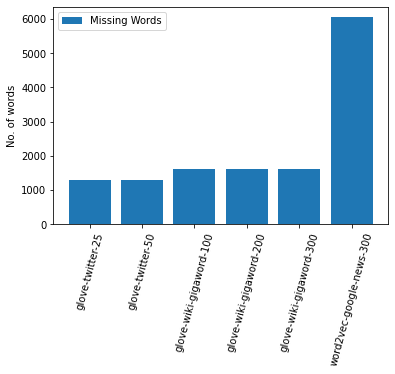

In [0]:
missing_words= [1297,1297,1603,1603,1603,6055]
x = np.array([0,1,2,3,4,5])
my_xticks = ['glove-twitter-25','glove-twitter-50','glove-wiki-gigaword-100','glove-wiki-gigaword-200','glove-wiki-gigaword-300','word2vec-google-news-300']
plt.xticks(x, my_xticks,rotation=75)

plt.bar(x,missing_words,label="Missing Words")


#plt.xlabel('Fold', fontsize=18)
plt.ylabel('No. of words', fontsize=10)
plt.legend(fontsize='medium')
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
plt.show()
plt.clf()
plt.cla()
plt.close()

### Term Frequency Document Frequency

In [0]:
tokenized_sentences = []
for sentence in train_data+validation_data+test_data:
    tokenized_sentences.append(sentence.split())

DF = {}

for tokensized_doc in tokenized_sentences:
    # get each unique word in the doc - we need to know whether the word is appeared in the document
    for term in np.unique(tokensized_doc):
        try:
            DF[term] +=1
        except:
            DF[term] =1

from collections import Counter
import math

tf_idf = {}

# total number of documents
N = len(tokenized_sentences)

doc_id = 0
# get each tokenised doc
for tokenized_sentence in tokenized_sentences:
    # initialise counter for the doc
    counter = Counter(tokenized_sentence)
    # calculate total number of words in the doc
    total_num_words = len(tokenized_sentence)    

    # get each unique word in the doc
    for term in np.unique(tokenized_sentence):

        #calculate Term Frequency 
        tf = counter[term]/total_num_words
        
        #calculate Document Frequency
        df = DF[term]

        # calculate Inverse Document Frequency
        idf = math.log(N/(df+1))+1

        # calculate TF-IDF
        tf_idf[doc_id, term] = tf*idf

    doc_id += 1

In [0]:
#Create input TFIDF for training, validation and testing dataset
train_tfidf = []
for id,sent in enumerate(train_data):
  try:
    train_tfidf.append([tf_idf[id,w] for w in sent.split()]) #Every element in the list will be a sub list of TFIDF value of the words in the corresponding line of dataset
  except:
    print("Error in",sent)
    print(id)
    break


validation_tfidf = []
for id,sent in enumerate(validation_data):
  try:
    #validation_indexes.append([word_to_ix[w] for w in sent.split()])
    validation_tfidf.append([tf_idf[len(train_data)+id,w] for w in sent.split()])
  except:
    print("Error in",sent)
    print(id)
    break


test_tfidf = []
for id,sent in enumerate(test_data):
  try:
    #test_indexes.append([word_to_ix[w] for w in sent.split()])
    test_tfidf.append([tf_idf[len(train_data)+len(validation_data)+id,w] for w in sent.split()])
  except:
    print("Error in",sent)
    print(id)
    break

### POS Tag

In [0]:
nltk.download('averaged_perceptron_tagger') #This will allow us to detect POS TAGS



train_postag = []
all_postag =[]
for id,sent in enumerate(train_data):
  try:
    #train_indexes.append([word_to_ix[w] for w in sent.split()])
    tmpresults = nltk.pos_tag(sent.split()) #Get POS TAGS for each word in the sentense
    train_postag.append([w[1] for w in tmpresults]) #Save POS TAG in train_postag
    all_postag.extend([w[1] for w in tmpresults])
  except:
    print("Error in",sent)
    print(id)
    break




validation_postag = []
for id,sent in enumerate(validation_data):
  try:
    #validation_indexes.append([word_to_ix[w] for w in sent.split()])
    tmpresults = nltk.pos_tag(sent.split())
    validation_postag.append([w[1] for w in tmpresults])
    all_postag.extend([w[1] for w in tmpresults])
  except:
    print("Error in",sent)
    print(id)
    break


test_postag = []
for id,sent in enumerate(test_data):
  try:
    #test_indexes.append([word_to_ix[w] for w in sent.split()]
    tmpresults = nltk.pos_tag(sent.split())
    test_postag.append([w[1] for w in tmpresults])
    all_postag.extend([w[1] for w in tmpresults])
  except:
    print("Error in",sent)
    print(id)
    break


unique_postag = set(all_postag)

#Create dictionary of POS TAG
postag_to_ix = {w: i for i, w in enumerate(unique_postag)}

#Function to convert POS Tags to index
def postag_to_index(data, to_ix):
    input_index_list = []
    for sent in data:
      try:
        input_index_list.append([to_ix[w] for w in sent])
      except:
        print("Error in",sent)
        break
    return input_index_list

#Convert and create index for training, validation and test POS TAG
train_postag_index =  postag_to_index(train_postag,postag_to_ix) 
validation_postag_index =  postag_to_index(validation_postag,postag_to_ix)
test_postag_index =  postag_to_index(test_postag,postag_to_ix)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Data Preprocessing for Character Embeddings

In [0]:
chars = [] #list for characters
wordlen = [] #list for words

for word in word_list:
  chars+=list(word)  #adding all characters to chars list for words used in word2vec embedding
  wordlen.append(len(word))  #adding the length of each word to wordlen list


char_arr = list(set(chars))  #adding unique characters in char_arr

char_dic = {n: i for i, n in enumerate(char_arr)}  #Creating a dictionary for indexing characters when required

char_dic_len = len(char_dic) #This will be the length of one hot vector for every character

maxword_len = max(wordlen)  
#print("Maximum word length : ",maxword_len)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)

### Length of words

In [0]:
#Function to create list of length of words
def sent_to_len(data):
  len_list = []
  for id,sent in enumerate(data):
    try:
      len_list.append([len(w) for w in sent.split()])  #Each element will contain list of length of each word
    except:
      print("Error in",sent)
      print(id)
      break
  return len_list

#Create and save length of words in respective lists
train_len =  sent_to_len(train_data)
validation_len =  sent_to_len(validation_data)
test_len =  sent_to_len(test_data)

### convert dataset into idxs

In [0]:
def to_index(data, to_ix):
    input_index_list = []
    for sent in data:
      try:
        input_index_list.append([to_ix[w] for w in sent.split()])
      except:
        print("Error in",sent)
        break
    return input_index_list

#Converting input data and output data for training into indexes for training
train_input_index =  to_index(train_data,word_to_ix)
train_output_index = to_index(target_y_train,tag_to_ix)
val_input_index = to_index(validation_data,word_to_ix)
val_output_index = to_index(target_y_validation,tag_to_ix)
test_input_index = to_index(test_data,word_to_ix)

## Model

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1) #Repeating embedding so that it can be repeated with embedding of all other words
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

### Function for calculating f1

In [0]:
import numpy as np
from sklearn.metrics import f1_score
def cal_acc(model, input_index, tfidf,postag,data,lenlist,output_index):
    correct_pred = 0
    total_pred = 0
    predicted = []
    ground_truth = []
    for x in range(len(input_index)):
      #For every item in the training or validation data create required inputs and then perform forward pass through the model
      sentence_input = torch.tensor(input_index[x], dtype=torch.long).to(device)
      tfidf_in = torch.tensor(tfidf[x], dtype=torch.float).to(device)
      postag_in = torch.tensor(postag[x], dtype=torch.float).to(device)
      lenlist_in=torch.tensor(lenlist[x], dtype=torch.float).to(device)
      words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in data[x].split()]
      _,pred_tags= model.forward(sentence_input,tfidf_in,postag_in,words,lenlist_in) #Perform forward pass and get the predictions
      correct_pred += sum(np.array(pred_tags) == np.array(output_index[x]))
      total_pred += len(output_index[x])
      predicted.extend(pred_tags) #Save Predictions
      ground_truth.extend(output_index[x]) #Save Actual output
    accuracy = correct_pred/total_pred
    #Calculate f1-score
    fone=f1_score(y_true=[ix_to_tag[output] for output in ground_truth], y_pred=[ix_to_tag[output] for output in predicted], average='micro')
    return ground_truth, predicted, accuracy,fone


### Initialize Model

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

In [0]:
#Uncomment to load a model checkpoint
#ckp_path = "/content/NER_11.pt"  #Uncomment to load a check point 
#model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer) #Uncomment to load a check point 
#EPOCHS=20

### Train Model

The below is the training and of the model with best results:
*   Input - Word2Vec, Character Embedding (Bi-LSTM)
*   Attention [Layer, Type] - [Self Attention, LSTM Output, Scaled Dot Product], [Self Attention, Imput Embedding, Dot Product]
*   NER Model - BiLSTM


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.94560614
Epoch:1, Training loss: 8292.86, val loss: 1110.14, train f1: 0.9518, val f1: 0.9456, time: 256.99s
Info : model f1-score Improved from 0.94560614 to 0.95434092
Epoch:2, Training loss: 4047.80, val loss: 923.60, train f1: 0.9668, val f1: 0.9543, time: 253.38s
Info : model f1-score Improved from 0.95434092 to 0.95698782
Epoch:3, Training loss: 2903.96, val loss: 881.96, train f1: 0.9737, val f1: 0.9570, time: 253.51s
Info : model f1-score Improved from 0.95698782 to 0.96228163
Epoch:4, Training loss: 2157.68, val loss: 847.79, train f1: 0.9797, val f1: 0.9623, time: 252.46s
Info : model f1-score Improved from 0.96228163 to 0.96360508
Epoch:5, Training loss: 1617.19, val loss: 872.26, train f1: 0.9833, val f1: 0.9636, time: 253.81s
Info : model f1-score Improved from 0.96360508 to 0.96598729
Epoch:6, Training loss: 1253.45, val loss: 847.28, train f1: 0.9862, val f1: 0.9660, time: 252.93s
Info : model f1-score Improved from 0.9659872

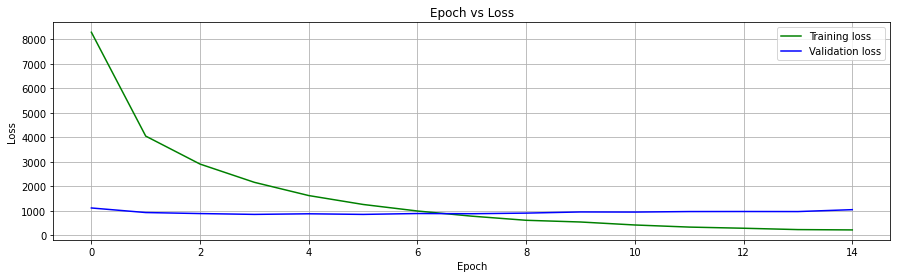

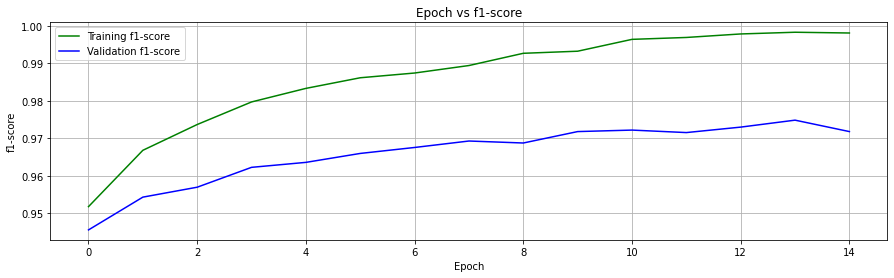

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

#### Load Best Weights

In [0]:
model.load_state_dict(best_model_wts) #Load weights of best f1

<All keys matched successfully>

#### Save Checkpoint (Optional)

In [0]:
#Uncomment to save checkpoint for future training
#checkpoint = {
#    'epoch': epoch + 1,
#    'state_dict': model.state_dict(),
#    'optimizer': optimizer.state_dict()
#}
#save_ckp(checkpoint, False, "/content/NER_checkpoint_"+str(epoch)+".pt","/content/NER_checkpoint_"+str(epoch)+".pt")  


#### Save Model (Optional)

In [0]:
import datetime

from google.colab import drive
drive.mount('/content/gdrive')

NERModelName = "NERModel-"+datetime.datetime.now().strftime("%d-%m-%Y-%H-%M")+"_hidden"+str(HIDDEN_DIM)+"_total_epoch"+str(epoch)+".pt"

nermodelpath = F"/content/gdrive/My Drive/"+NERModelName 
torch.save(model, nermodelpath)
#drive.flush_and_unmount()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Generating Predictions

In [0]:
predicted = []
ground_truth = []
for x in range(len(test_input_index)):      
      sentence_input = torch.tensor(test_input_index[x], dtype=torch.long).to(device)
      tfidf_in = torch.tensor(test_tfidf[x], dtype=torch.float).to(device)
      postag_in= torch.tensor(test_postag_index[x], dtype=torch.float).to(device)
      lenlist_in=torch.tensor(test_len[x], dtype=torch.float).to(device)
      words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in test_data[x].split()]
      _,pred_tags= model.forward(sentence_input,tfidf_in,postag_in,words,lenlist_in)
      #For every test data perform forward pass and get the predictions
      predicted.extend(pred_tags)

#Convert index of predictions to the actual tags
test_pred=[ix_to_tag[output] for output in predicted]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [0]:
#Save predictions to file 
import pandas as pd
pred_csv = pd.DataFrame(test_pred)
pred_csv.columns = ['Predicted']
pred_csv.index.name = 'Id'
pred_csv.to_csv('Predicted_labels_'+datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")+'.txt',index = True)

## Test 1

Scenario Details:
*   Input -Word2Vec
*   Attention Layer - Self Attention - LSTM out
*   Attention Type - Dot Product
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = True
USE_SCALED_DOTPRODUCT_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
        
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(1, 2),embeds),dim=-1)
            attn_output = torch.bmm(embeds,attn_weights.transpose(1, 2))
            embeds = torch.cat((embeds,attn_output), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(1, 2),embeds)/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(embeds,attn_weights.transpose(1, 2))
            embeds = torch.cat((embeds,attn_output), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
      

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.93144521
Epoch:1, Training loss: 10923.01, val loss: 1453.68, train f1: 0.9388, val f1: 0.9314, time: 195.96s
Info : model f1-score Improved from 0.93144521 to 0.94163579
Epoch:2, Training loss: 5274.96, val loss: 1236.29, train f1: 0.9547, val f1: 0.9416, time: 193.89s
Info : model f1-score Improved from 0.94163579 to 0.95037057
Epoch:3, Training loss: 3945.24, val loss: 1119.67, train f1: 0.9641, val f1: 0.9504, time: 192.53s
Info : model f1-score Improved from 0.95037057 to 0.95076760
Epoch:4, Training loss: 3078.41, val loss: 1133.59, train f1: 0.9695, val f1: 0.9508, time: 191.62s
Info : model f1-score Improved from 0.95076760 to 0.95341451
Epoch:5, Training loss: 2461.33, val loss: 1142.37, train f1: 0.9728, val f1: 0.9534, time: 190.43s
Info : model f1-score Improved from 0.95341451 to 0.95381154
Epoch:6, Training loss: 2028.14, val loss: 1150.82, train f1: 0.9749, val f1: 0.9538, time: 190.20s
Epoch:7, Training loss: 1657.01, val lo

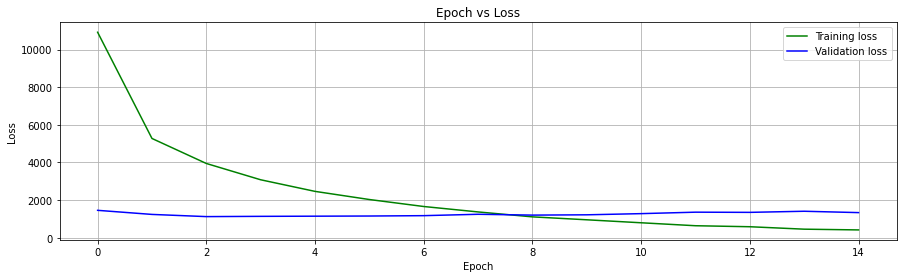

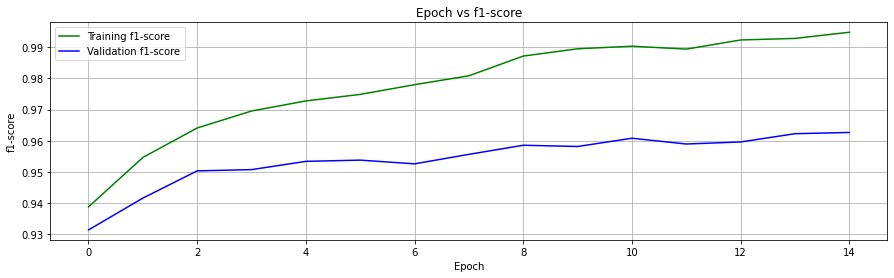

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 2

Scenario Details:
*   Input -Word2Vec
*   Attention Layer - Self Attention - LSTM out
*   Attention Type - Content Base Attention
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = True


#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN == True or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim

        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(1, 2),embeds),dim=-1)
            attn_output = torch.bmm(embeds,attn_weights.transpose(1, 2))
            embeds = torch.cat((embeds,attn_output), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(1, 2),embeds)/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(embeds,attn_weights.transpose(1, 2))
            embeds = torch.cat((embeds,attn_output), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.93303335
Epoch:1, Training loss: 11065.69, val loss: 1449.99, train f1: 0.9382, val f1: 0.9330, time: 241.76s
Info : model f1-score Improved from 0.93303335 to 0.94348862
Epoch:2, Training loss: 5254.84, val loss: 1205.74, train f1: 0.9560, val f1: 0.9435, time: 242.43s
Info : model f1-score Improved from 0.94348862 to 0.94997353
Epoch:3, Training loss: 3912.51, val loss: 1089.73, train f1: 0.9646, val f1: 0.9500, time: 240.71s
Info : model f1-score Improved from 0.94997353 to 0.95156167
Epoch:4, Training loss: 3070.42, val loss: 1087.35, train f1: 0.9700, val f1: 0.9516, time: 238.85s
Info : model f1-score Improved from 0.95156167 to 0.95354685
Epoch:5, Training loss: 2451.09, val loss: 1123.51, train f1: 0.9727, val f1: 0.9535, time: 237.31s
Info : model f1-score Improved from 0.95354685 to 0.95473796
Epoch:6, Training loss: 2042.69, val loss: 1155.11, train f1: 0.9742, val f1: 0.9547, time: 237.28s
Epoch:7, Training loss: 1651.91, val lo

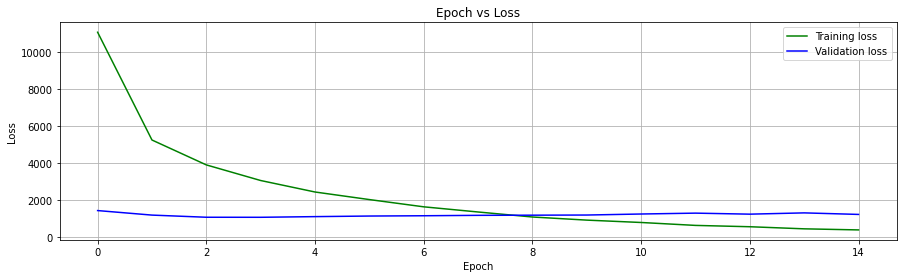

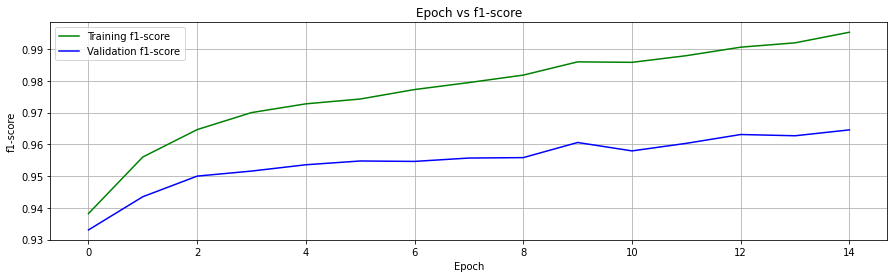

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 3

Scenario Details:
*   Input -Word2Vec, Word Length
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = True
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.91357861
Epoch:1, Training loss: 10258.86, val loss: 1848.55, train f1: 0.9250, val f1: 0.9136, time: 186.54s
Info : model f1-score Improved from 0.91357861 to 0.92681313
Epoch:2, Training loss: 5887.93, val loss: 1504.90, train f1: 0.9409, val f1: 0.9268, time: 191.24s
Info : model f1-score Improved from 0.92681313 to 0.93065114
Epoch:3, Training loss: 4641.42, val loss: 1323.64, train f1: 0.9478, val f1: 0.9307, time: 198.07s
Info : model f1-score Improved from 0.93065114 to 0.94044468
Epoch:4, Training loss: 3767.60, val loss: 1158.45, train f1: 0.9559, val f1: 0.9404, time: 200.86s
Info : model f1-score Improved from 0.94044468 to 0.94454738
Epoch:5, Training loss: 3174.67, val loss: 1135.80, train f1: 0.9612, val f1: 0.9445, time: 202.91s
Epoch:6, Training loss: 2755.76, val loss: 1167.04, train f1: 0.9633, val f1: 0.9432, time: 204.14s
Info : model f1-score Improved from 0.94454738 to 0.94692959
Epoch:7, Training loss: 2375.13, val lo

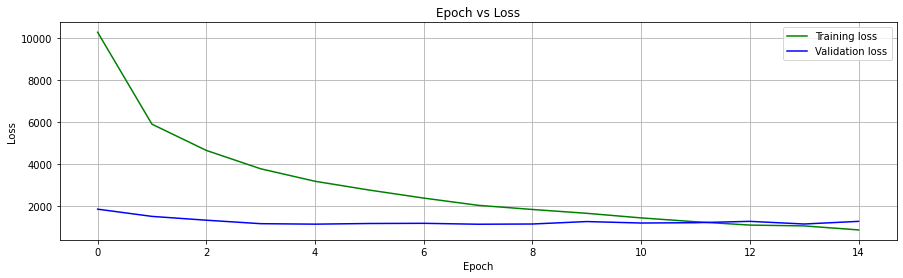

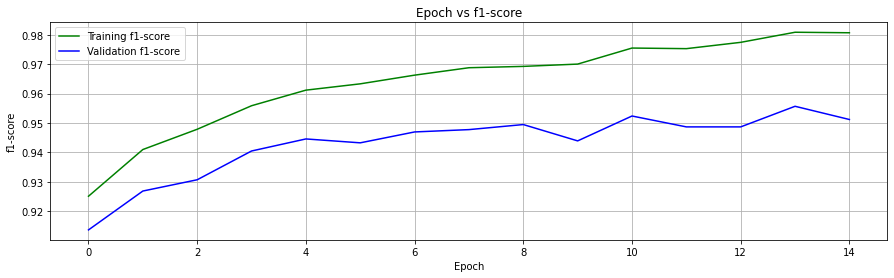

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 4

Scenario Details:
*   Input - Word2Vec
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = False #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

Info : model f1-score Improved from -inf to 0.93938592
Epoch:1, Training loss: 10848.15, val loss: 1346.70, train f1: 0.9430, val f1: 0.9394, time: 189.74s
Info : model f1-score Improved from 0.93938592 to 0.95037057
Epoch:2, Training loss: 5245.69, val loss: 1095.30, train f1: 0.9563, val f1: 0.9504, time: 185.54s
Info : model f1-score Improved from 0.95037057 to 0.95341451
Epoch:3, Training loss: 3922.68, val loss: 1025.06, train f1: 0.9640, val f1: 0.9534, time: 184.81s
Epoch:4, Training loss: 3024.80, val loss: 1012.20, train f1: 0.9706, val f1: 0.9526, time: 184.00s
Epoch:5, Training loss: 2483.69, val loss: 1063.75, train f1: 0.9734, val f1: 0.9521, time: 184.28s
Info : model f1-score Improved from 0.95341451 to 0.95513499
Epoch:6, Training loss: 1973.63, val loss: 1074.31, train f1: 0.9778, val f1: 0.9551, time: 185.78s
Info : model f1-score Improved from 0.95513499 to 0.95606141
Epoch:7, Training loss: 1646.36, val loss: 1039.04, train f1: 0.9810, val f1: 0.9561, time: 183.17s


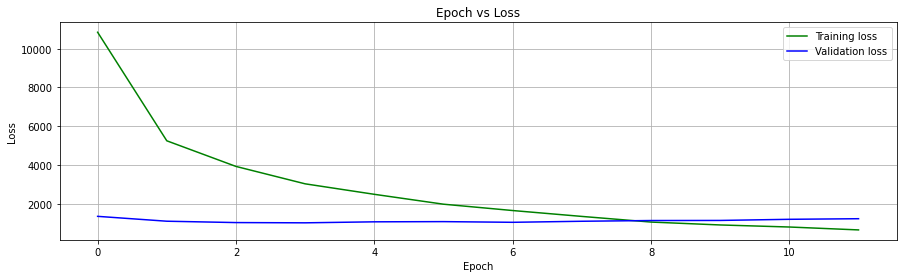

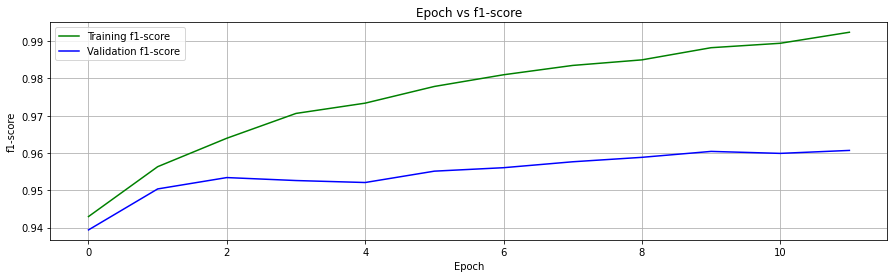

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 5

Scenario Details:
*   Input - Word2Vec, TFIDF
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = True
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = False #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

Info : model f1-score Improved from -inf to 0.93501853
Epoch:1, Training loss: 10487.20, val loss: 1387.20, train f1: 0.9420, val f1: 0.9350, time: 301.52s
Info : model f1-score Improved from 0.93501853 to 0.94772366
Epoch:2, Training loss: 5079.86, val loss: 1096.45, train f1: 0.9564, val f1: 0.9477, time: 303.27s
Info : model f1-score Improved from 0.94772366 to 0.94931181
Epoch:3, Training loss: 3788.85, val loss: 1030.34, train f1: 0.9647, val f1: 0.9493, time: 300.99s
Info : model f1-score Improved from 0.94931181 to 0.95487030
Epoch:4, Training loss: 2982.60, val loss: 966.84, train f1: 0.9717, val f1: 0.9549, time: 301.44s
Info : model f1-score Improved from 0.95487030 to 0.95606141
Epoch:5, Training loss: 2367.43, val loss: 983.55, train f1: 0.9744, val f1: 0.9561, time: 304.91s
Info : model f1-score Improved from 0.95606141 to 0.95778190
Epoch:6, Training loss: 1917.86, val loss: 973.46, train f1: 0.9796, val f1: 0.9578, time: 304.82s
Info : model f1-score Improved from 0.9577

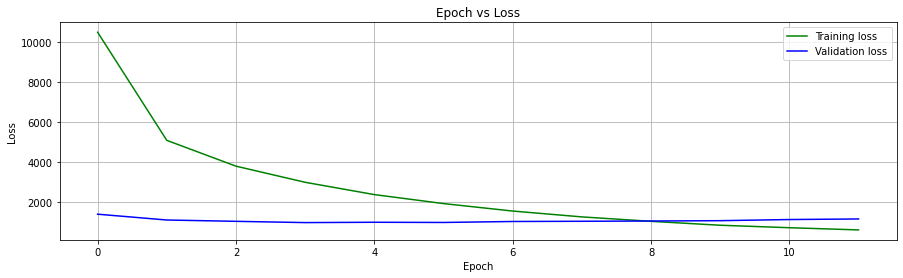

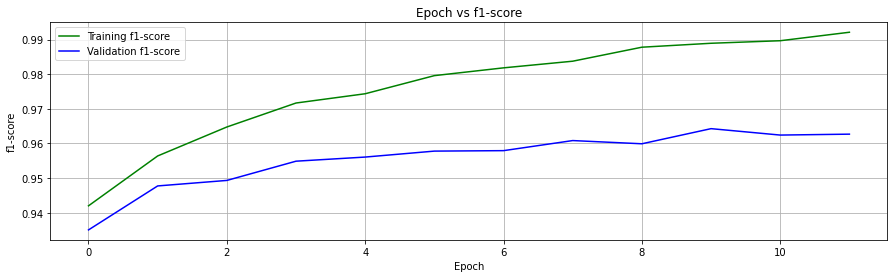

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 6

Scenario Details:
*   Input - Word2Vec, POSTAG
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 12
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =True
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = False #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

Info : model f1-score Improved from -inf to 0.83033351
Epoch:1, Training loss: 18691.54, val loss: 3470.25, train f1: 0.8516, val f1: 0.8303, time: 192.78s
Epoch:2, Training loss: 12881.74, val loss: 3383.52, train f1: 0.8523, val f1: 0.8182, time: 195.98s
Info : model f1-score Improved from 0.83033351 to 0.90577025
Epoch:3, Training loss: 10447.67, val loss: 2130.89, train f1: 0.9055, val f1: 0.9058, time: 196.67s
Epoch:4, Training loss: 9046.64, val loss: 2746.51, train f1: 0.8852, val f1: 0.8579, time: 197.55s
Info : model f1-score Improved from 0.90577025 to 0.91238751
Epoch:5, Training loss: 8504.66, val loss: 1940.60, train f1: 0.9205, val f1: 0.9124, time: 197.89s
Info : model f1-score Improved from 0.91238751 to 0.91966649
Epoch:6, Training loss: 7463.34, val loss: 1862.60, train f1: 0.9262, val f1: 0.9197, time: 197.35s
Epoch:7, Training loss: 6664.76, val loss: 2215.35, train f1: 0.8959, val f1: 0.8818, time: 197.96s
Epoch:8, Training loss: 6602.44, val loss: 2194.69, train f

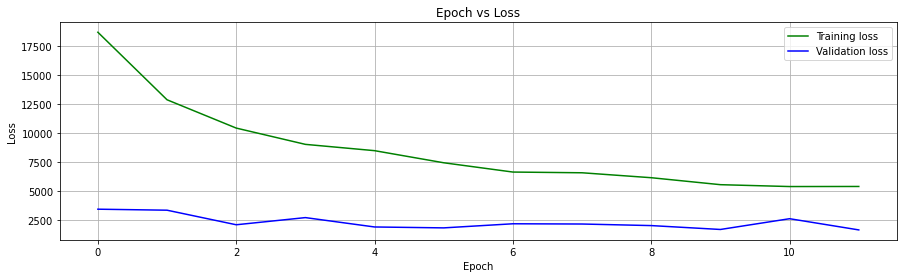

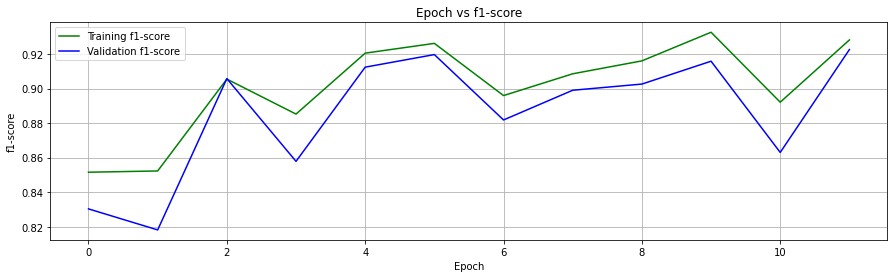

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 7

Scenario Details:
*   Input - Word2Vec
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiLSTM - 2 layers

In [0]:
#Hyperparamters for training
EPOCHS = 12
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = False #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 2 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

Info : model f1-score Improved from -inf to 0.92151932
Epoch:1, Training loss: 13704.22, val loss: 1604.77, train f1: 0.9262, val f1: 0.9215, time: 190.46s
Info : model f1-score Improved from 0.92151932 to 0.93753309
Epoch:2, Training loss: 6013.02, val loss: 1270.99, train f1: 0.9500, val f1: 0.9375, time: 195.09s
Info : model f1-score Improved from 0.93753309 to 0.94415034
Epoch:3, Training loss: 4269.57, val loss: 1157.95, train f1: 0.9597, val f1: 0.9442, time: 196.64s
Info : model f1-score Improved from 0.94415034 to 0.94494442
Epoch:4, Training loss: 3234.19, val loss: 1160.83, train f1: 0.9662, val f1: 0.9449, time: 195.35s
Info : model f1-score Improved from 0.94494442 to 0.94719428
Epoch:5, Training loss: 2605.28, val loss: 1186.04, train f1: 0.9701, val f1: 0.9472, time: 196.74s
Info : model f1-score Improved from 0.94719428 to 0.95407623
Epoch:6, Training loss: 2072.37, val loss: 1090.98, train f1: 0.9762, val f1: 0.9541, time: 196.59s
Epoch:7, Training loss: 1752.59, val lo

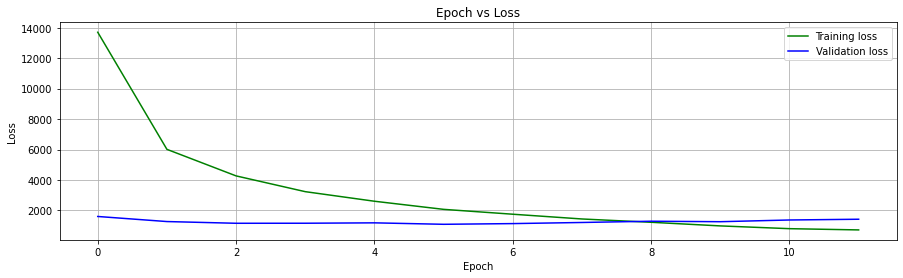

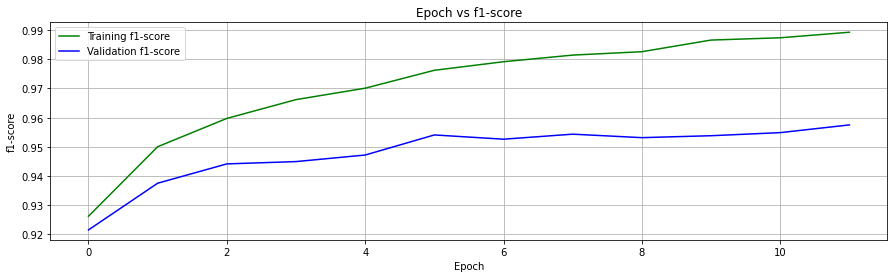

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 8

Scenario Details:
*   Input - Word2Vec
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiLSTM - 3 layers

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = False #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 3 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.88790365
Epoch:1, Training loss: 19691.57, val loss: 2423.24, train f1: 0.8848, val f1: 0.8879, time: 340.17s
Info : model f1-score Improved from 0.88790365 to 0.92151932
Epoch:2, Training loss: 8264.36, val loss: 1599.75, train f1: 0.9325, val f1: 0.9215, time: 338.97s
Info : model f1-score Improved from 0.92151932 to 0.93753309
Epoch:3, Training loss: 5556.91, val loss: 1342.70, train f1: 0.9526, val f1: 0.9375, time: 342.23s
Info : model f1-score Improved from 0.93753309 to 0.94150344
Epoch:4, Training loss: 4203.09, val loss: 1238.70, train f1: 0.9595, val f1: 0.9415, time: 342.98s
Info : model f1-score Improved from 0.94150344 to 0.94362096
Epoch:5, Training loss: 3373.70, val loss: 1191.63, train f1: 0.9640, val f1: 0.9436, time: 338.67s
Info : model f1-score Improved from 0.94362096 to 0.94904711
Epoch:6, Training loss: 2750.93, val loss: 1143.68, train f1: 0.9700, val f1: 0.9490, time: 336.27s
Info : model f1-score Improved from 0.9

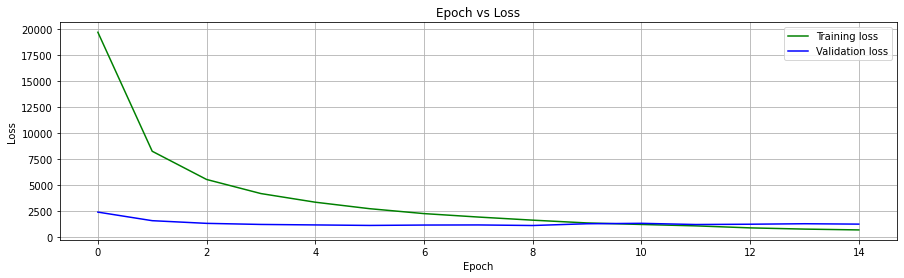

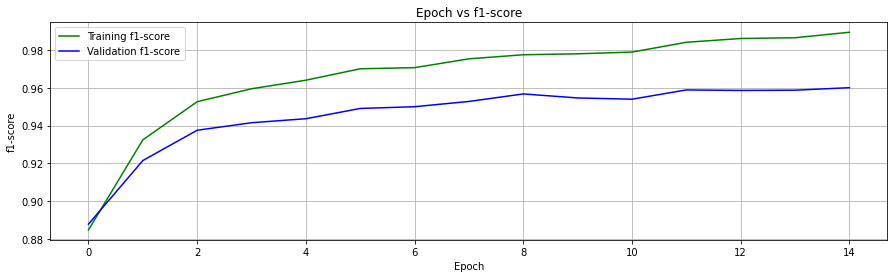

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 9

Scenario Details:
*   Input - Word2Vec, Character Based Embedding LSTM
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiLSTM - 1 layer

In [0]:
#Hyperparamters for training
EPOCHS = 12
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = False #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.93978295
Epoch:1, Training loss: 10082.20, val loss: 1258.84, train f1: 0.9447, val f1: 0.9398, time: 237.29s
Info : model f1-score Improved from 0.93978295 to 0.95103229
Epoch:2, Training loss: 4671.75, val loss: 1003.31, train f1: 0.9590, val f1: 0.9510, time: 236.18s
Info : model f1-score Improved from 0.95103229 to 0.95553203
Epoch:3, Training loss: 3482.68, val loss: 941.09, train f1: 0.9661, val f1: 0.9555, time: 232.21s
Info : model f1-score Improved from 0.95553203 to 0.95857597
Epoch:4, Training loss: 2710.67, val loss: 894.33, train f1: 0.9715, val f1: 0.9586, time: 236.49s
Epoch:5, Training loss: 2179.65, val loss: 933.31, train f1: 0.9753, val f1: 0.9574, time: 235.96s
Info : model f1-score Improved from 0.95857597 to 0.95923769
Epoch:6, Training loss: 1736.38, val loss: 953.59, train f1: 0.9783, val f1: 0.9592, time: 230.53s
Info : model f1-score Improved from 0.95923769 to 0.96082583
Epoch:7, Training loss: 1427.63, val loss: 

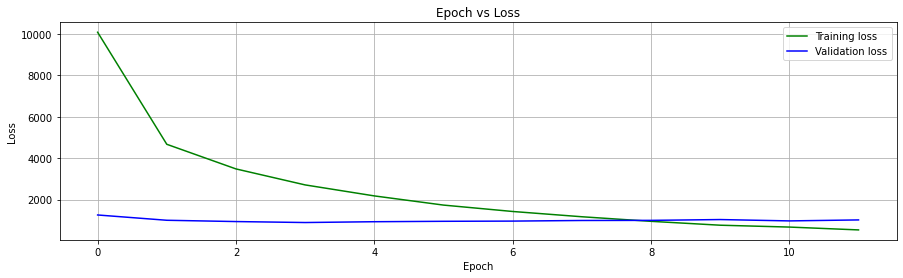

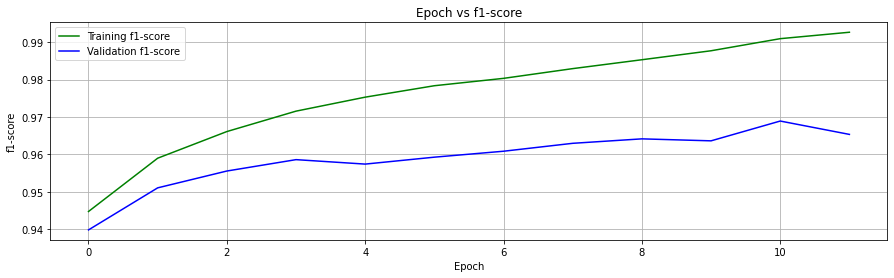

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 10

Scenario Details:
*   Input - Word2Vec, Character Based Embedding Bi-LSTM
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiLSTM - 1 layer

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.93991530
Epoch:1, Training loss: 9042.50, val loss: 1195.78, train f1: 0.9463, val f1: 0.9399, time: 232.05s
Info : model f1-score Improved from 0.93991530 to 0.94851773
Epoch:2, Training loss: 4478.47, val loss: 998.83, train f1: 0.9600, val f1: 0.9485, time: 231.83s
Info : model f1-score Improved from 0.94851773 to 0.95381154
Epoch:3, Training loss: 3397.70, val loss: 914.64, train f1: 0.9672, val f1: 0.9538, time: 231.83s
Info : model f1-score Improved from 0.95381154 to 0.95725251
Epoch:4, Training loss: 2693.21, val loss: 857.06, train f1: 0.9724, val f1: 0.9573, time: 231.85s
Info : model f1-score Improved from 0.95725251 to 0.96095818
Epoch:5, Training loss: 2154.97, val loss: 836.18, train f1: 0.9782, val f1: 0.9610, time: 232.05s
Info : model f1-score Improved from 0.96095818 to 0.96373743
Epoch:6, Training loss: 1758.37, val loss: 819.04, train f1: 0.9813, val f1: 0.9637, time: 231.81s
Info : model f1-score Improved from 0.9637374

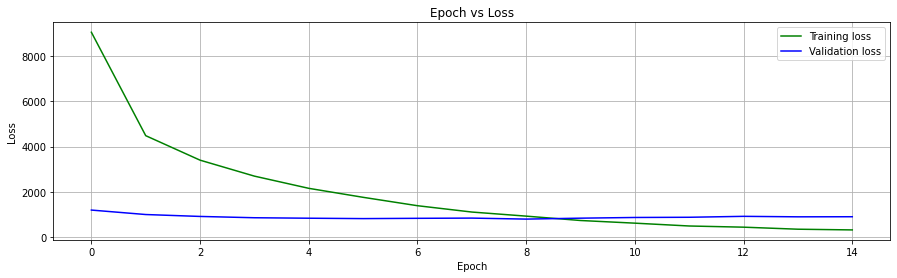

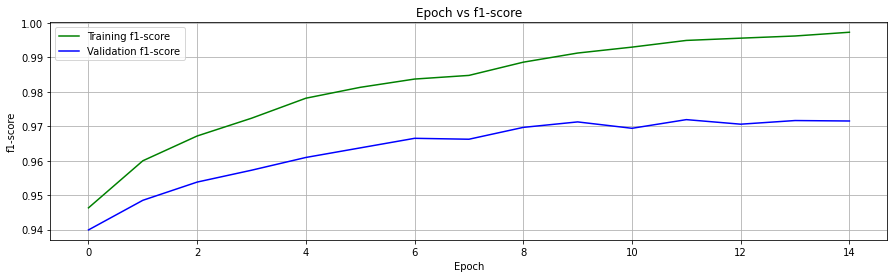

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        
        #print(sentence_in)
        #print(sentence_in.shape)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()


## Test 11

Scenario Details:
*   Input - Word2Vec
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiGRU - 1 layer

In [0]:
#Hyperparamters for training
EPOCHS = 12
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = False #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = True #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0

### Train Model

Info : model f1-score Improved from -inf to 0.93435680
Epoch:1, Training loss: 9205.86, val loss: 1490.27, train f1: 0.9385, val f1: 0.9344, time: 190.54s
Info : model f1-score Improved from 0.93435680 to 0.94348862
Epoch:2, Training loss: 5177.03, val loss: 1193.86, train f1: 0.9552, val f1: 0.9435, time: 189.28s
Info : model f1-score Improved from 0.94348862 to 0.94626787
Epoch:3, Training loss: 3752.51, val loss: 1080.26, train f1: 0.9655, val f1: 0.9463, time: 188.30s
Info : model f1-score Improved from 0.94626787 to 0.95169402
Epoch:4, Training loss: 2856.04, val loss: 1056.09, train f1: 0.9727, val f1: 0.9517, time: 190.38s
Info : model f1-score Improved from 0.95169402 to 0.95526734
Epoch:5, Training loss: 2167.64, val loss: 1031.98, train f1: 0.9787, val f1: 0.9553, time: 191.32s
Info : model f1-score Improved from 0.95526734 to 0.95884066
Epoch:6, Training loss: 1687.84, val loss: 1069.49, train f1: 0.9820, val f1: 0.9588, time: 187.96s
Epoch:7, Training loss: 1296.94, val los

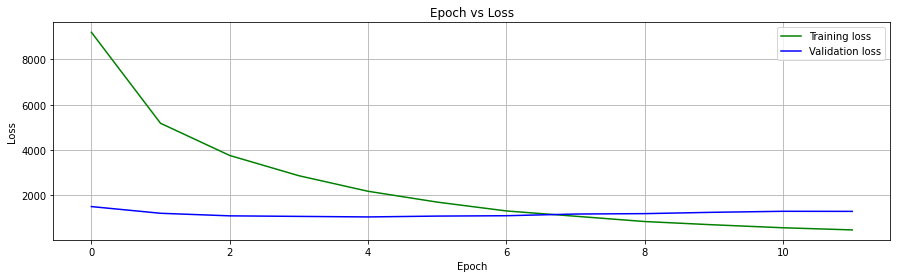

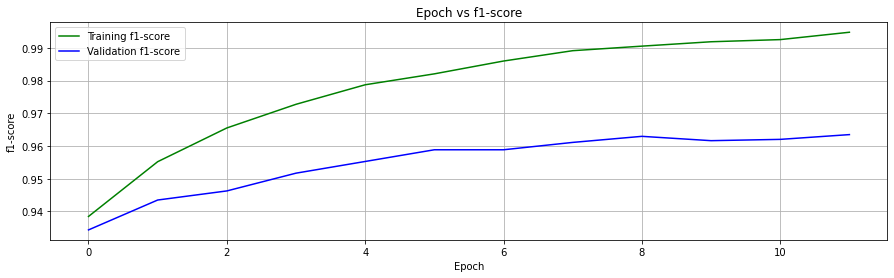

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        
        #print(sentence_in)
        #print(sentence_in.shape)
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,val_output_index)

    val_loss = 0
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()


## Test 12

Scenario Details:
*   Input -Word2Vec, Character Embedding (Bi-LSTM)
*   Attention Layer - Self Attention - Input Embedding
*   Attention Type - Dot Product
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = True
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1))
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.93859185
Epoch:1, Training loss: 9149.96, val loss: 1228.35, train f1: 0.9436, val f1: 0.9386, time: 254.16s
Info : model f1-score Improved from 0.93859185 to 0.94904711
Epoch:2, Training loss: 4543.07, val loss: 1016.71, train f1: 0.9594, val f1: 0.9490, time: 253.67s
Info : model f1-score Improved from 0.94904711 to 0.95394389
Epoch:3, Training loss: 3330.91, val loss: 948.59, train f1: 0.9681, val f1: 0.9539, time: 252.55s
Info : model f1-score Improved from 0.95394389 to 0.95725251
Epoch:4, Training loss: 2609.92, val loss: 911.96, train f1: 0.9741, val f1: 0.9573, time: 252.61s
Info : model f1-score Improved from 0.95725251 to 0.96109052
Epoch:5, Training loss: 2062.59, val loss: 874.02, train f1: 0.9775, val f1: 0.9611, time: 252.79s
Info : model f1-score Improved from 0.96109052 to 0.96532557
Epoch:6, Training loss: 1634.63, val loss: 836.10, train f1: 0.9828, val f1: 0.9653, time: 252.17s
Epoch:7, Training loss: 1292.11, val loss: 9

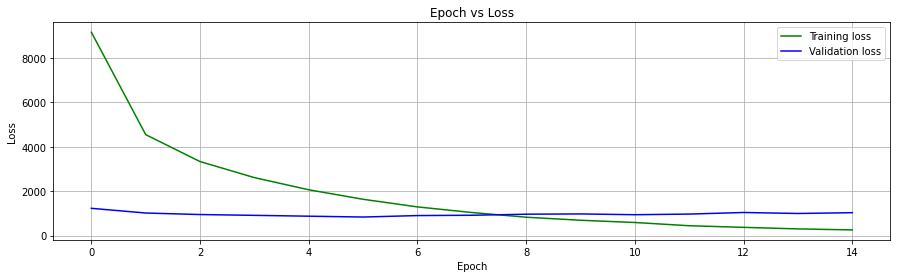

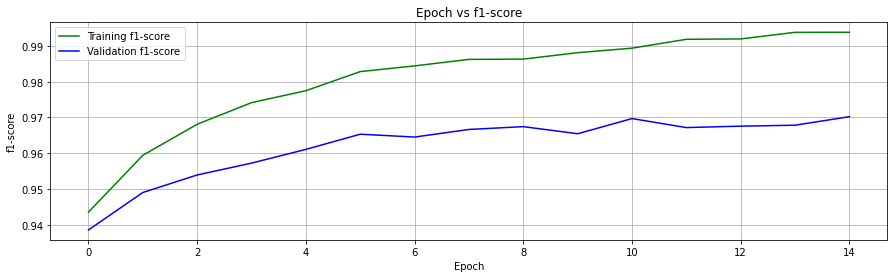

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 13

Scenario Details:
*   Input -Word2Vec, Character Embedding (Bi-LSTM)
*   Attention Layer - Self Attention - Input Embedding
*   Attention Type - Content Base Attention
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = True

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.94216517
Epoch:1, Training loss: 9155.07, val loss: 1217.97, train f1: 0.9457, val f1: 0.9422, time: 298.25s
Info : model f1-score Improved from 0.94216517 to 0.94745897
Epoch:2, Training loss: 4558.82, val loss: 1015.34, train f1: 0.9584, val f1: 0.9475, time: 304.28s
Info : model f1-score Improved from 0.94745897 to 0.95394389
Epoch:3, Training loss: 3320.12, val loss: 910.27, train f1: 0.9688, val f1: 0.9539, time: 302.91s
Info : model f1-score Improved from 0.95394389 to 0.95685548
Epoch:4, Training loss: 2592.17, val loss: 891.87, train f1: 0.9750, val f1: 0.9569, time: 297.21s
Info : model f1-score Improved from 0.95685548 to 0.95976707
Epoch:5, Training loss: 2029.51, val loss: 880.58, train f1: 0.9774, val f1: 0.9598, time: 295.24s
Info : model f1-score Improved from 0.95976707 to 0.96095818
Epoch:6, Training loss: 1609.61, val loss: 862.93, train f1: 0.9808, val f1: 0.9610, time: 295.09s
Info : model f1-score Improved from 0.960958

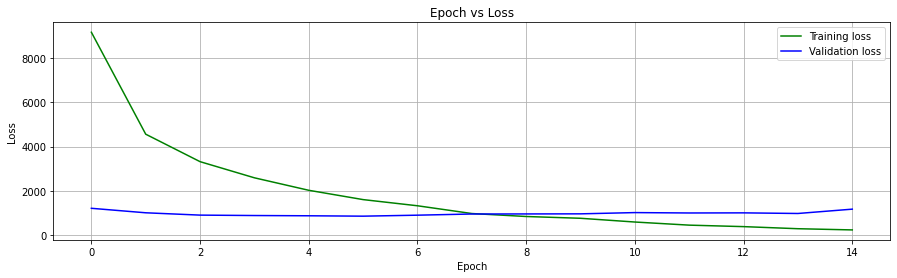

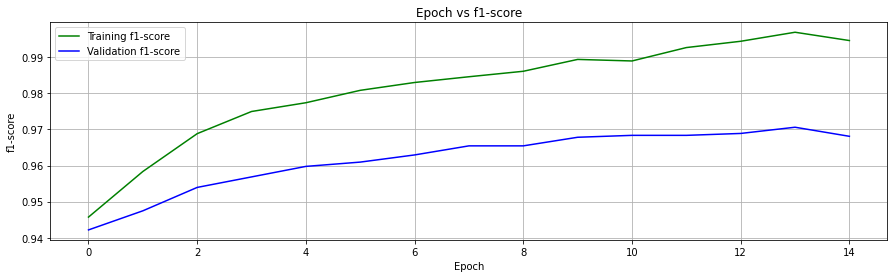

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 14

Scenario Details:
*   Input -Word2Vec, Character Embedding (Bi-LSTM)
*   Attention Layer - Self Attention - Input Embedding
*   Attention Type - Dot Product
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =True
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.94242986
Epoch:1, Training loss: 8409.64, val loss: 1164.76, train f1: 0.9509, val f1: 0.9424, time: 441.60s
Info : model f1-score Improved from 0.94242986 to 0.95513499
Epoch:2, Training loss: 3990.20, val loss: 944.42, train f1: 0.9660, val f1: 0.9551, time: 442.59s
Info : model f1-score Improved from 0.95513499 to 0.95884066
Epoch:3, Training loss: 2864.39, val loss: 918.15, train f1: 0.9732, val f1: 0.9588, time: 441.98s
Info : model f1-score Improved from 0.95884066 to 0.96281101
Epoch:4, Training loss: 2160.68, val loss: 871.14, train f1: 0.9783, val f1: 0.9628, time: 444.26s
Info : model f1-score Improved from 0.96281101 to 0.96704606
Epoch:5, Training loss: 1679.46, val loss: 838.56, train f1: 0.9820, val f1: 0.9670, time: 442.28s
Epoch:6, Training loss: 1280.24, val loss: 881.09, train f1: 0.9845, val f1: 0.9657, time: 441.18s
Epoch:7, Training loss: 1000.59, val loss: 917.08, train f1: 0.9866, val f1: 0.9647, time: 441.35s
Epoch:8

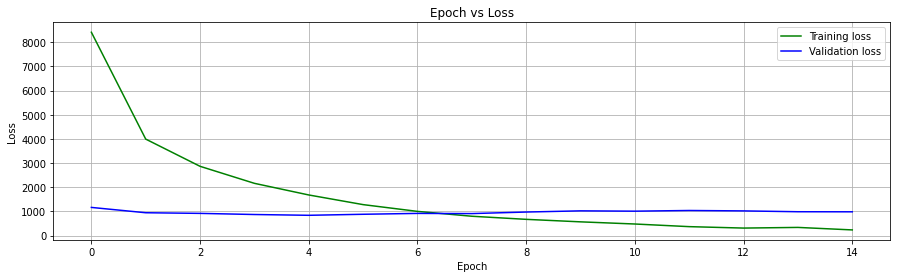

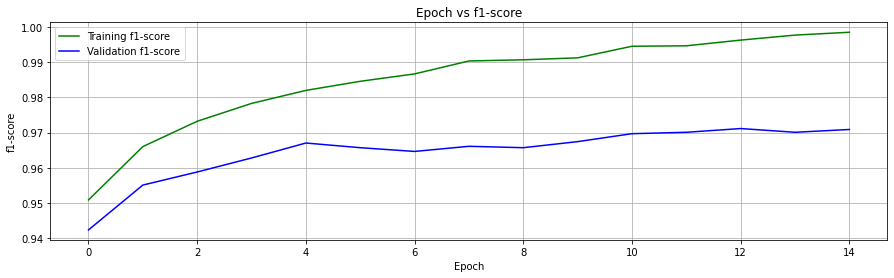

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 15

Scenario Details:
*   Input -Word2Vec, Character Embedding (Bi-LSTM)
*   Attention Layer - Self Attention - LSTM Output
*   Attention Type - Dot Product
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = True
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.94017999
Epoch:1, Training loss: 8942.72, val loss: 1183.87, train f1: 0.9495, val f1: 0.9402, time: 263.31s
Info : model f1-score Improved from 0.94017999 to 0.94878242
Epoch:2, Training loss: 4415.64, val loss: 976.39, train f1: 0.9608, val f1: 0.9488, time: 253.92s
Info : model f1-score Improved from 0.94878242 to 0.95592906
Epoch:3, Training loss: 3289.38, val loss: 881.59, train f1: 0.9681, val f1: 0.9559, time: 252.11s
Info : model f1-score Improved from 0.95592906 to 0.95804659
Epoch:4, Training loss: 2556.19, val loss: 891.45, train f1: 0.9756, val f1: 0.9580, time: 250.43s
Epoch:5, Training loss: 2050.35, val loss: 931.22, train f1: 0.9777, val f1: 0.9579, time: 250.07s
Info : model f1-score Improved from 0.95804659 to 0.95870831
Epoch:6, Training loss: 1689.32, val loss: 959.97, train f1: 0.9797, val f1: 0.9587, time: 250.06s
Epoch:7, Training loss: 1329.10, val loss: 1068.54, train f1: 0.9796, val f1: 0.9584, time: 249.98s
Epoch:

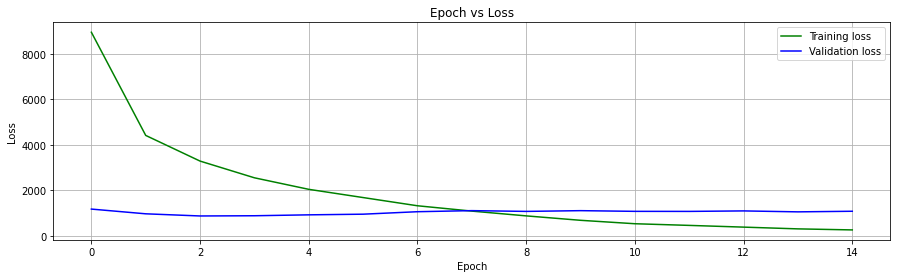

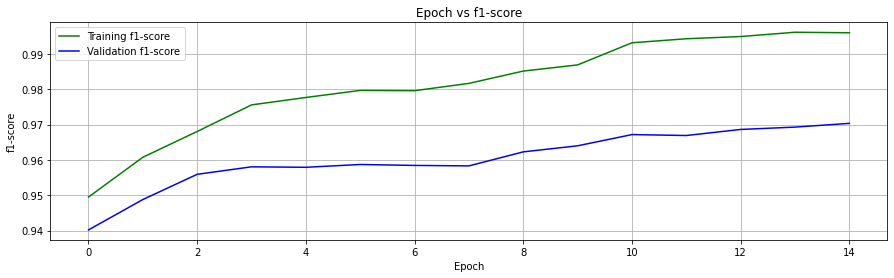

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 16

Scenario Details:
*   Input -Word2Vec, Character Embedding (Bi-LSTM)
*   Attention Layer - Self Attention - LSTM Output
*   Attention Type - Scaled Dot Product
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = True
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.93938592
Epoch:1, Training loss: 9143.27, val loss: 1208.73, train f1: 0.9478, val f1: 0.9394, time: 250.09s
Info : model f1-score Improved from 0.93938592 to 0.94798835
Epoch:2, Training loss: 4416.98, val loss: 999.84, train f1: 0.9598, val f1: 0.9480, time: 250.70s
Info : model f1-score Improved from 0.94798835 to 0.95394389
Epoch:3, Training loss: 3262.68, val loss: 922.94, train f1: 0.9678, val f1: 0.9539, time: 251.48s
Info : model f1-score Improved from 0.95394389 to 0.95645844
Epoch:4, Training loss: 2560.65, val loss: 887.23, train f1: 0.9743, val f1: 0.9565, time: 251.67s
Info : model f1-score Improved from 0.95645844 to 0.95976707
Epoch:5, Training loss: 1980.80, val loss: 848.69, train f1: 0.9782, val f1: 0.9598, time: 254.83s
Info : model f1-score Improved from 0.95976707 to 0.96188460
Epoch:6, Training loss: 1555.79, val loss: 909.60, train f1: 0.9809, val f1: 0.9619, time: 253.58s
Epoch:7, Training loss: 1262.44, val loss: 91

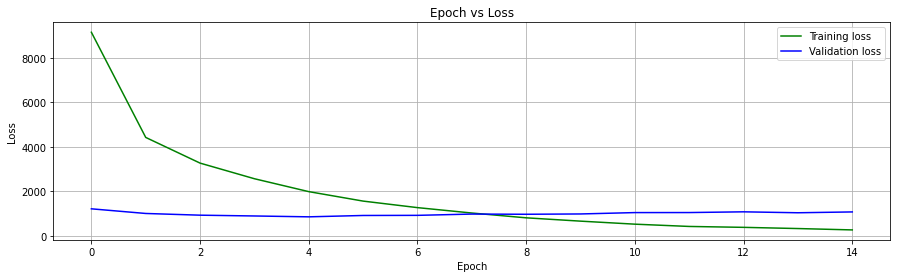

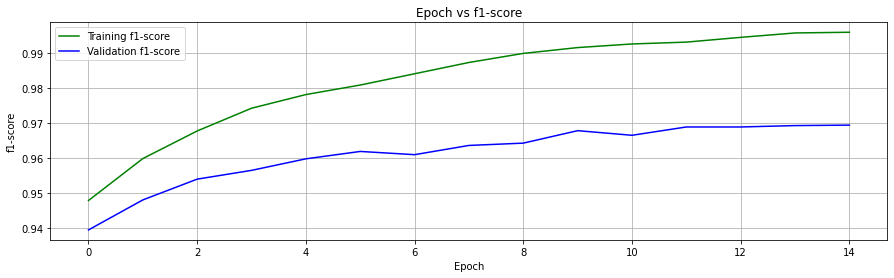

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 17

Scenario Details:
*   Input -Word2Vec, Character Embedding (Bi-LSTM)
*   Attention Layer - Self Attention - LSTM Output
*   Attention Type - Content Base
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = True

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.93898888
Epoch:1, Training loss: 9125.92, val loss: 1220.71, train f1: 0.9471, val f1: 0.9390, time: 302.36s
Info : model f1-score Improved from 0.93898888 to 0.95010588
Epoch:2, Training loss: 4410.65, val loss: 1001.45, train f1: 0.9604, val f1: 0.9501, time: 305.04s
Info : model f1-score Improved from 0.95010588 to 0.95447327
Epoch:3, Training loss: 3281.72, val loss: 909.13, train f1: 0.9693, val f1: 0.9545, time: 304.38s
Info : model f1-score Improved from 0.95447327 to 0.95791424
Epoch:4, Training loss: 2557.96, val loss: 854.47, train f1: 0.9745, val f1: 0.9579, time: 303.11s
Info : model f1-score Improved from 0.95791424 to 0.95923769
Epoch:5, Training loss: 2035.15, val loss: 869.86, train f1: 0.9777, val f1: 0.9592, time: 305.66s
Info : model f1-score Improved from 0.95923769 to 0.96095818
Epoch:6, Training loss: 1621.58, val loss: 912.14, train f1: 0.9801, val f1: 0.9610, time: 307.87s
Info : model f1-score Improved from 0.960958

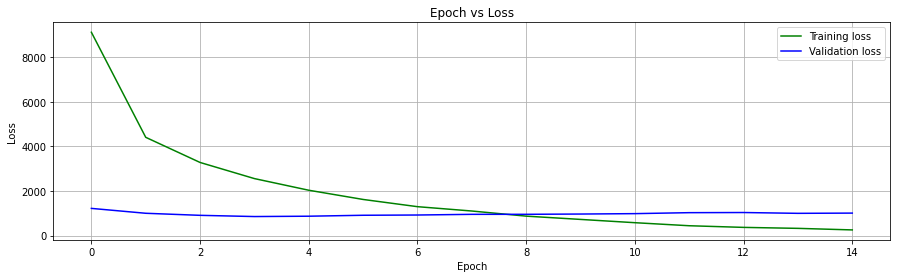

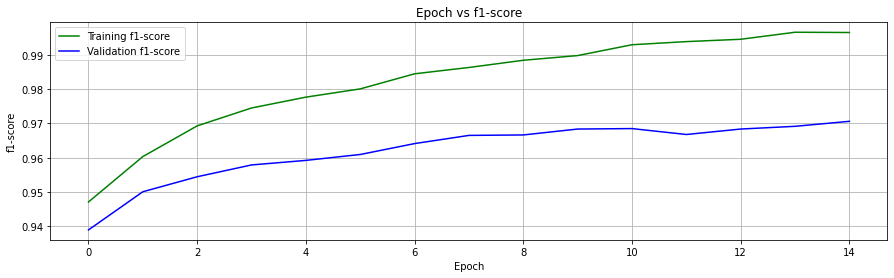

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 18

Scenario Details:
*   Input -Word2Vec, Character Embedding (Bi-LSTM 2 layers)
*   Attention Layer - NA
*   Attention Type - NA
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 2 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = False
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          #attn_weights = F.softmax(torch.bmm(lstm_out.transpose(1, 2),lstm_out),dim=-1)
          #attn_output = torch.bmm(lstm_out,attn_weights.transpose(1, 2))  #Transpose can be removed and tried
          #concat_output = torch.cat((attn_output, lstm_out), 1)
          #concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          #lstm_feats = self.hidden2tag(concat_output)
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.94057702
Epoch:1, Training loss: 8853.34, val loss: 1214.10, train f1: 0.9458, val f1: 0.9406, time: 287.86s
Info : model f1-score Improved from 0.94057702 to 0.94732663
Epoch:2, Training loss: 4485.96, val loss: 1032.63, train f1: 0.9587, val f1: 0.9473, time: 287.53s
Info : model f1-score Improved from 0.94732663 to 0.95367920
Epoch:3, Training loss: 3331.10, val loss: 967.99, train f1: 0.9670, val f1: 0.9537, time: 288.57s
Info : model f1-score Improved from 0.95367920 to 0.95950238
Epoch:4, Training loss: 2640.02, val loss: 901.62, train f1: 0.9728, val f1: 0.9595, time: 288.56s
Epoch:5, Training loss: 2089.47, val loss: 880.62, train f1: 0.9774, val f1: 0.9588, time: 287.31s
Info : model f1-score Improved from 0.95950238 to 0.96307570
Epoch:6, Training loss: 1677.97, val loss: 894.94, train f1: 0.9804, val f1: 0.9631, time: 287.69s
Info : model f1-score Improved from 0.96307570 to 0.96545791
Epoch:7, Training loss: 1299.96, val loss: 8

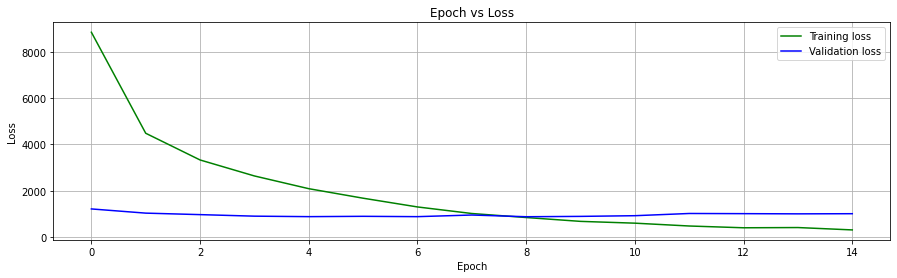

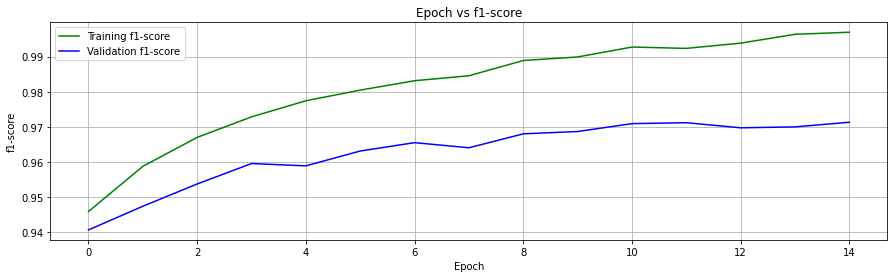

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

## Test 19

Scenario Details:
*   Input -Word2Vec
*   Attention [Layer, Type] - [Self Attention, LSTM Output, Scaled Dot Product]
*   NER Model - BiLSTM

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = False

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = True
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =False
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = False #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.93290101
Epoch:1, Training loss: 11087.38, val loss: 1449.04, train f1: 0.9384, val f1: 0.9329, time: 183.82s
Info : model f1-score Improved from 0.93290101 to 0.94282689
Epoch:2, Training loss: 5258.18, val loss: 1203.58, train f1: 0.9561, val f1: 0.9428, time: 183.31s
Info : model f1-score Improved from 0.94282689 to 0.95063526
Epoch:3, Training loss: 3913.84, val loss: 1083.17, train f1: 0.9644, val f1: 0.9506, time: 183.24s
Info : model f1-score Improved from 0.95063526 to 0.95142933
Epoch:4, Training loss: 3070.60, val loss: 1084.36, train f1: 0.9700, val f1: 0.9514, time: 183.36s
Info : model f1-score Improved from 0.95142933 to 0.95354685
Epoch:5, Training loss: 2452.10, val loss: 1120.74, train f1: 0.9727, val f1: 0.9535, time: 182.85s
Info : model f1-score Improved from 0.95354685 to 0.95447327
Epoch:6, Training loss: 2042.50, val loss: 1154.95, train f1: 0.9747, val f1: 0.9545, time: 182.05s
Epoch:7, Training loss: 1652.95, val lo

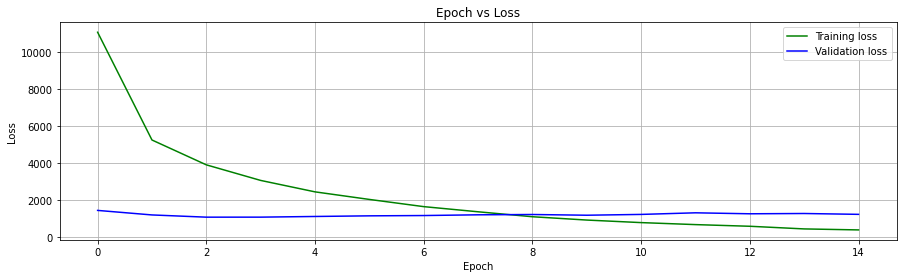

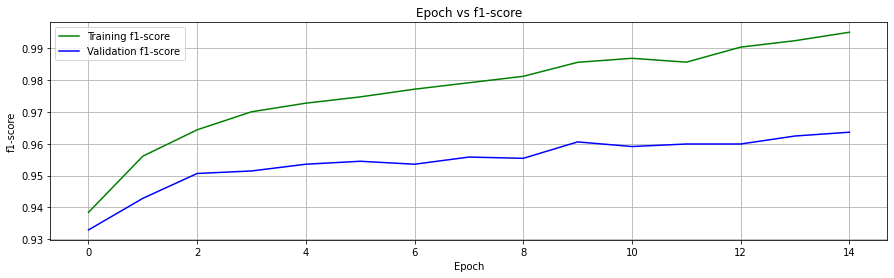

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()


## Test 20

Scenario Details:
*   Input -Word2Vec, Character Embedding (Bi-LSTM)
*   Attention [Layer, Type] - [Self Attention, LSTM Output, Scaled Dot Product], [Self Attention, Imput Embedding, Dot Product]
*   NER Model - BiGRU

In [0]:
#Hyperparamters for training
EPOCHS = 15
HIDDEN_DIM = 50

#Dataset to be used for word2vec embeddings
GENISM_DATASET = "glove-wiki-gigaword-100"

#Input Features to be used - as many as required can be set to true. Word2Vec will be default
USETFIDF = False
USE_POSTAG =False
USE_WORDLENGTH = False
USE_CHARBASEDWORD2VEC = True

#Inputs for Character LSTM Model. Only applicable if USE_CHARBASEDWORD2VEC = True
CHAR_HIDDEN_DIM = 50 #Number of neurons in hidden layers
CHAR_BIDIRECTIONAL = True #True for BiLSTM else LSTM
CHAR_NUM_LAYERS = 1 #Number of LSTM layers

#The below are for applying self attention to BILSTM / BIGRU of the model before linear layer. A maximum of one of two should be True.
USE_DOTPRODUCT_SELFATTN = False
USE_SCALED_DOTPRODUCT_SELFATTN = True
USE_CONTENTBASE_SELFATTN = False

#The below are for applying self attention between input embeddings.
#A maximum of one of two should be True.
USE_DOTPRODUCT_ATTN4 =True
USE_SCALED_DOTPRODUCT_ATTN4 = False
USE_CONTENTBASE_ATTN4 = False

#Inputs for the Model Build
NUM_LAYERS = 1 #1 for normal Bi-LSTM / BiGRU else stacked Bi-LSTM, stacked Bi-GRU
USE_GRU = True #If True Bi-GRU will be used, else Bi-LSTM

### Build Model

In [0]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(1)

def argmax(vec):
    # return the argmax as a python int
    _, idx = torch.max(vec, 1)
    return idx.item()


# Compute log sum exp in a numerically stable way for the forward algorithm
def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim,char_dic_len,char_hidden_dim):
        super(BiLSTM_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)
        self.char_dic_len = char_dic_len  #Length of number of unique characters

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.char_embedding = nn.Embedding(char_dic_len, embedding_dim) #Embedding for character based word embedding

        self.word_embeds.weight.data.copy_(torch.from_numpy(embedding_matrix)) #Copying weights from genism datatset for our words

        lstm_in=embedding_dim
        #Modifying LSTM inputs based on the features selected
        if USETFIDF == True:
          lstm_in=lstm_in+1

        if USE_POSTAG == True:
          lstm_in=lstm_in+1

        if USE_WORDLENGTH == True:
          lstm_in=lstm_in+1

        if USE_CHARBASEDWORD2VEC ==True:
          if CHAR_BIDIRECTIONAL == False:
            lstm_in=lstm_in+CHAR_NUM_LAYERS*char_hidden_dim
          else:
            lstm_in=lstm_in+2*CHAR_NUM_LAYERS*char_hidden_dim

        #Attn 4 is applied on inputs features and hence increaseing them
        if USE_DOTPRODUCT_ATTN4 == True or USE_SCALED_DOTPRODUCT_ATTN4 == True or USE_CONTENTBASE_ATTN4 == True:
          lstm_in=lstm_in+lstm_in

        #Using GRU or LSTM depending on inputs
        if USE_GRU == True:
          self.lstm = nn.GRU(lstm_in, hidden_dim // 2,num_layers=NUM_LAYERS, bidirectional=True)
        else:
          self.lstm = nn.LSTM(lstm_in, hidden_dim // 2,
                            num_layers=NUM_LAYERS, bidirectional=True)
        
        #LSTM for character based word embedding model
        self.char_lstm = nn.LSTM(embedding_dim, char_hidden_dim,num_layers=CHAR_NUM_LAYERS, bidirectional=CHAR_BIDIRECTIONAL)

        # Modifying input to linear layer based on the attention selected
        hidden2tag_dim=hidden_dim
        if USE_DOTPRODUCT_SELFATTN == True or USE_SCALED_DOTPRODUCT_SELFATTN or USE_CONTENTBASE_SELFATTN == True:
          hidden2tag_dim=hidden2tag_dim+hidden_dim
    
        self.linear_in_dim= hidden2tag_dim
        self.lstm_in =lstm_in
        self.hidden2tag = nn.Linear(hidden2tag_dim, self.tagset_size)

        # Matrix of transition parameters.  Entry i,j is the score of
        # transitioning *to* i *from* j.
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size))

        # These two statements enforce the constraint that we never transfer
        # to the start tag and we never transfer from the stop tag
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
      if USE_GRU == True:
        return torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device)
      else:
        return (torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device),
                torch.randn(2*NUM_LAYERS, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        # Do the forward algorithm to compute the partition function
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        # START_TAG has all of the score.
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        # Wrap in a variable so that we will get automatic backprop
        forward_var = init_alphas

        # Iterate through the sentence
        for feat in feats:
            alphas_t = []  # The forward tensors at this timestep
            for next_tag in range(self.tagset_size):
                # broadcast the emission score: it is the same regardless of
                # the previous tag
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                # the ith entry of trans_score is the score of transitioning to
                # next_tag from i
                trans_score = self.transitions[next_tag].view(1, -1)
                # The ith entry of next_tag_var is the value for the
                # edge (i -> next_tag) before we do log-sum-exp
                next_tag_var = forward_var + trans_score + emit_score
                # The forward variable for this tag is log-sum-exp of all the
                # scores.
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence,tfidf,postag,words,lenlist):
        
        #print(embeds.shape)
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1) #Get embeddings for words in the sentence
        
        #Addint TFIDF, POSTAG, Word length, Character Embedding to the inputs features depending on Flags entered
        if USETFIDF ==True:
          tfidf = tfidf.view(tfidf.shape[0],1,1)
          embeds = torch.cat([embeds,tfidf],dim=2)

        if USE_POSTAG ==True:
          postag = postag.view(postag.shape[0],1,1)
          embeds = torch.cat([embeds,postag],dim=2)

        if USE_WORDLENGTH == True:
          lenlist = lenlist.view(lenlist.shape[0],1,1)
          embeds = torch.cat([embeds,lenlist],dim=2)

        char_hidden_final = []
        if USE_CHARBASEDWORD2VEC == True:
          #Get embedding and pass through LSTM and get the last hidden state for every word
          for word in words:
              char_embeds = self.char_embedding(word)
              char_embeds = char_embeds.view(len(word), 1, -1) #char_embeds.view(1,1,char_embeds.shape[0])
              _, (char_hidden, char_cell_state) = self.char_lstm(char_embeds)
              word_char_hidden_state = char_hidden.view(-1)
              char_hidden_final.append(word_char_hidden_state)
          char_hidden_final = torch.stack(tuple(char_hidden_final))
          char_hidden_final  = torch.unsqueeze(char_hidden_final,1)
          embeds = torch.cat([embeds, char_hidden_final], dim=2)

        #Self attention among the entire input embeddings
        if USE_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2)),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_SCALED_DOTPRODUCT_ATTN4 == True:
            attn_weights = F.softmax(torch.bmm(embeds.transpose(0, 1),embeds.transpose(0, 1).transpose(1, 2))/math.sqrt(self.lstm_in),dim=-1)
            attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
            embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)
        elif USE_CONTENTBASE_ATTN4 == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(embeds)):
            tmp= embeds[x].repeat(len(embeds),1)
            output = cos(tmp.unsqueeze(1),embeds)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,embeds.transpose(0, 1))
          embeds = torch.cat((embeds,attn_output.transpose(0,1)), 2)

        lstm_out, self.hidden = self.lstm(embeds, self.hidden)

        #Self Attention between LSTM outputs
        if USE_DOTPRODUCT_SELFATTN == True:     
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2)),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)


        elif USE_SCALED_DOTPRODUCT_SELFATTN == True:
          attn_weights = F.softmax(torch.bmm(lstm_out.transpose(0, 1),lstm_out.transpose(0, 1).transpose(1, 2))/math.sqrt(self.hidden_dim // 2),dim=-1)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)

          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)

        elif USE_CONTENTBASE_SELFATTN == True:
          cos = nn.CosineSimilarity(dim=2, eps=1e-6)
          cosinesim = []
          for x in range(len(lstm_out)):
            tmp= lstm_out[x].repeat(len(lstm_out),1)
            output = cos(tmp.unsqueeze(1),lstm_out)
            output = F.softmax(output,dim=0).transpose(0,1)
            cosinesim.append(output[0])       
          cosinesim = torch.stack(tuple(cosinesim))
          attn_weights  = torch.unsqueeze(cosinesim,0)
          attn_output = torch.bmm(attn_weights,lstm_out.transpose(0, 1))
          concat_output = torch.cat((attn_output.transpose(0,1), lstm_out), 1)
          concat_output = concat_output.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(concat_output)
          #attn_weights = F.softmax(cos(lstm_out.transpose(1, 2),lstm_out),dim=-1)
        else:
          lstm_out = lstm_out.view(len(sentence), self.linear_in_dim)
          lstm_feats = self.hidden2tag(lstm_out)  #Pass through Linear layer after LSTM
        return lstm_feats

    def _score_sentence(self, feats, tags):
        # Gives the score of a provided tag sequence
       
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])

        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        # Initialize the viterbi variables in log space
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        # forward_var at step i holds the viterbi variables for step i-1
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  # holds the backpointers for this step
            viterbivars_t = []  # holds the viterbi variables for this step

            for next_tag in range(self.tagset_size):
                # next_tag_var[i] holds the viterbi variable for tag i at the
                # previous step, plus the score of transitioning
                # from tag i to next_tag.
                # We don't include the emission scores here because the max
                # does not depend on them (we add them in below)
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            # Now add in the emission scores, and assign forward_var to the set
            # of viterbi variables we just computed
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1)
            backpointers.append(bptrs_t)

        # Transition to STOP_TAG
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        # Follow the back pointers to decode the best path.
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        # Pop off the start tag (we dont want to return that to the caller)
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  # Sanity check
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence,tfidf,postag, words,lenlist,tags):
        feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence,tfidf,postag,words,lenlist):  # dont confuse this with _forward_alg above.
        # Get the emission scores from the BiLSTM
        lstm_feats = self._get_lstm_features(sentence,tfidf,postag,words,lenlist)
        # Find the best path, given the features.
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = BiLSTM_CRF(len(word_to_ix), tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM,char_dic_len,CHAR_HIDDEN_DIM).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-4)
best_f1 = np.NINF
start_epoch = 0


### Train Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Info : model f1-score Improved from -inf to 0.93938592
Epoch:1, Training loss: 7838.35, val loss: 1315.39, train f1: 0.9487, val f1: 0.9394, time: 255.18s
Info : model f1-score Improved from 0.93938592 to 0.94494442
Epoch:2, Training loss: 4177.04, val loss: 1153.79, train f1: 0.9640, val f1: 0.9449, time: 255.26s
Info : model f1-score Improved from 0.94494442 to 0.95288512
Epoch:3, Training loss: 2968.57, val loss: 1079.40, train f1: 0.9726, val f1: 0.9529, time: 254.80s
Info : model f1-score Improved from 0.95288512 to 0.95619375
Epoch:4, Training loss: 2140.60, val loss: 1080.36, train f1: 0.9767, val f1: 0.9562, time: 261.34s
Info : model f1-score Improved from 0.95619375 to 0.95725251
Epoch:5, Training loss: 1609.72, val loss: 1140.30, train f1: 0.9804, val f1: 0.9573, time: 257.02s
Info : model f1-score Improved from 0.95725251 to 0.96545791
Epoch:6, Training loss: 1105.61, val loss: 1133.55, train f1: 0.9859, val f1: 0.9655, time: 256.56s
Info : model f1-score Improved from 0.96

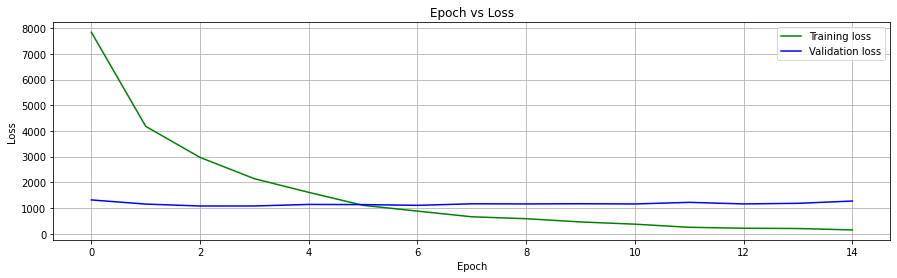

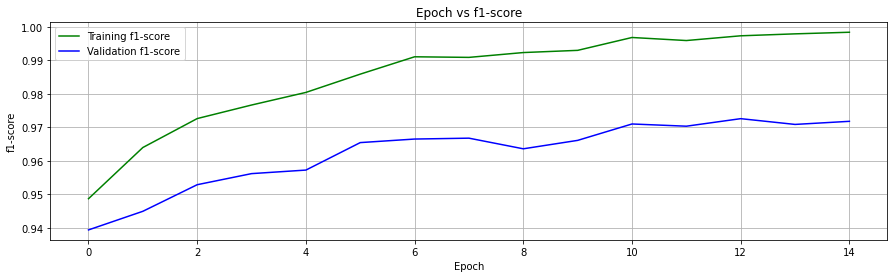

<All keys matched successfully>

In [0]:
import datetime

train_loss_l = []
val_loss_l = []
train_fone_l = []
val_fone_l=[]

for epoch in range(start_epoch,EPOCHS):  
    time1 = datetime.datetime.now()
    train_loss = 0

    model.train()
    for i, idxs in enumerate(train_input_index):
        tags_index = train_output_index[i]
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is,
        # turn them into Tensors of word indices.
        #print("In Train")
        #print(idxs)
        
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(train_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(train_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(train_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in train_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)

        # Step 3. Run our forward pass.

        loss = model.neg_log_likelihood(sentence_in, tfidf_in,postag_in,words,lenlist_in,targets)

        # Step 4. Compute the loss, gradients, and update the parameters by
        # calling optimizer.step()
        loss.backward()
        optimizer.step()

        train_loss+=loss.item()

    model.eval()
    #Calculate training f1 and validation f1
    _, _, train_acc,train_fone = cal_acc(model,train_input_index,train_tfidf,train_postag_index,train_data,train_len,train_output_index)
    _, _, val_acc,val_fone = cal_acc(model,val_input_index,validation_tfidf,validation_postag_index,validation_data,validation_len,val_output_index)

    val_loss = 0
    #Calculate validation loss
    for i, idxs in enumerate(val_input_index):
        tags_index = val_output_index[i]
        sentence_in = torch.tensor(idxs, dtype=torch.long).to(device)
        tfidf_in = torch.tensor(validation_tfidf[i], dtype=torch.float).to(device)
        postag_in = torch.tensor(validation_postag_index[i], dtype=torch.float).to(device)
        lenlist_in=torch.tensor(validation_len[i], dtype=torch.float).to(device)
        words = [torch.tensor(sequence_to_idx(s, char_dic), dtype=torch.long).to(device) for s in validation_data[i].split()]
        targets = torch.tensor(tags_index, dtype=torch.long).to(device)
        loss = model.neg_log_likelihood(sentence_in,tfidf_in,postag_in, words,lenlist_in,targets)
        val_loss+=loss.item()
    time2 = datetime.datetime.now()
    #Save weights if the f1 score has improved
    if val_fone > best_f1:
      print("Info : model f1-score Improved from {:.8f} to {:.8f}".format(best_f1,val_fone))
      best_f1 = val_fone
      best_model_wts = copy.deepcopy(model.state_dict())

    print("Epoch:%d, Training loss: %.2f, val loss: %.2f, train f1: %.4f, val f1: %.4f, time: %.2fs" %(epoch+1, train_loss, val_loss,train_fone,val_fone, (time2-time1).total_seconds()))
    #Store loss and f1 for plotting
    train_loss_l.append(train_loss)
    val_loss_l.append(val_loss)
    train_fone_l.append(train_fone)
    val_fone_l.append(val_fone)

plt.figure(figsize=(15,4))
plt.plot(train_loss_l,label="Training loss",color="green")
plt.plot(val_loss_l,label="Validation loss",color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(15,4))
plt.plot(train_fone_l,label="Training f1-score",color="green")
plt.plot(val_fone_l,label="Validation f1-score",color="blue")
plt.xlabel("Epoch")
plt.ylabel("f1-score")
plt.title("Epoch vs f1-score")
plt.legend()
plt.grid()
plt.show()

model.load_state_dict(best_model_wts) #Load weights of best f1

# References

1. Use of averaged_perceptron_tagger from nltk to identify POS tags